## Coulomb Stopping Powers

Module stoppingpower contains routines for numerical integration of stopping powers for incident charged particles Coulomb scattering off a $T=0$ Fermi sea of electrons.  No asumptions are made about the incident particle's mass or initial kinematics.   

In [22]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15,10]

import stoppingpower as sp

In [24]:
m_electron = 0.5 # MeV
Z_electron = -1.0 # charge
n_electron = 10**32 # cm^{-3}, electron number density

M_carbon = 10**4 # MeV
Z_carbon = 6.0
M_pion = 10**2 # Mev
Z_pion = 1.0
M_heavy = 10**6 # Mev
Z_heavy = 1.0

Initialize Fermi Sea properties, and construct stopping power functions.  This sets the energy unit to be MeV and the stopping power will be given in MeV/cm.

In [25]:
wd = sp.FermiSea_StoppingPower(m=m_electron, n0=n_electron, 
                               masstolength=sp.MeV_to_InvCM)
dedx_carbon_func = wd.get_ion_coulomb_stopping_power(M_carbon, Z_carbon)
dedx_pion_func = wd.get_ion_coulomb_stopping_power(M_pion, Z_pion)
dedx_heavy_func = wd.get_ion_coulomb_stopping_power(M_heavy, Z_heavy)

Stopping power functions accept an (array of) incident kinetic energy and do a monte carlo integral over electron momentum, direction, and com scattering angle.  

In [26]:
dedx_carbon_func(100.0, samples=1000)

array([[ 3518220.74762928],
       [ 1145571.45224854]])

In [27]:
timeit dedx_carbon_func([10.0**-2, 1.0, 100.0, 10**4, 10**6], samples=1000)

1 loop, best of 3: 295 ms per loop


Timing: 0.2 sec per 1000 samples. 
Need at least 10^5 samples for percent-level accuracy - thats at least 20 sec per calculation or about 3 hours to construct a 500 point plot. 

#### carbon ion and pion tests


In [41]:
ke = np.logspace(-4, 9, 100)  # 100 samples log-spaced between 10^-4 and 10^9
dedx_carbon, dedx_carbon_error = dedx_carbon_func(ke, samples=10**5, important=True)
dedx_pion, dedx_pion_error = dedx_pion_func(ke, samples=10**5, important=True)
dedx_heavy, dedx_heavy_error = dedx_heavy_func(ke, samples=10**5, important=True)


stoppingpower can also construct an approximate function based on the limiting cases of small or large incident momentum, both in the limit of a heavy incident and relativistic targets ('high density'). The function high_density_limiting is the quadrature sum of these two limits. 

The low energy limit is valid as long as incident momentum is non-relativisitc and greater than the target momentum (and maybe greater than the target mass as well...not sure).  This is Paul's esitmate, and gives $dE/dx \sim E^{1/2}$ ($E$ is incident kinetic energy). This involves an integral over scattering and incident angles which becomes an overall constant factor in the limit of incident momentum larger than the electron momentum. I haven't done this integral, but rather set the factor by eye.   

The high energy limit takes the electrons to be at rest and the incident to be highly relativistic, which gives a constant stopping power a la Jackson. I've used the exact Jackson result, with the Coulomb log set to $10$.  I suspect that for highly relativistic electrons this result is still valid for energetic enough incident particles, but the factor of electron mass ought to be replaced by the electron total energy ('relativistic inertia').  I have used the electron mass here, which ought to be fine as the electrons are only $\sim O(1)$ relativistic for WD densities.   

In [42]:
dedx_carbon_riggins_func = wd.high_density_slow_ion(M_carbon, Z_carbon)
dedx_carbon_jackson_func = wd.high_density_fast_ion(M_carbon, Z_carbon)
dedx_pion_riggins_func = wd.high_density_slow_ion(M_pion, Z_pion)
dedx_pion_jackson_func = wd.high_density_fast_ion(M_pion, Z_pion)
dedx_heavy_riggins_func = wd.high_density_slow_ion(M_heavy, Z_heavy)
dedx_heavy_jackson_func = wd.high_density_fast_ion(M_heavy, Z_heavy)

def momentum_threshold(p_electron, M_ion):
    """ The minimum incident momentum at which the low-energy PR estimate is valid """
    return (p_electron**2)/(2*M_ion)

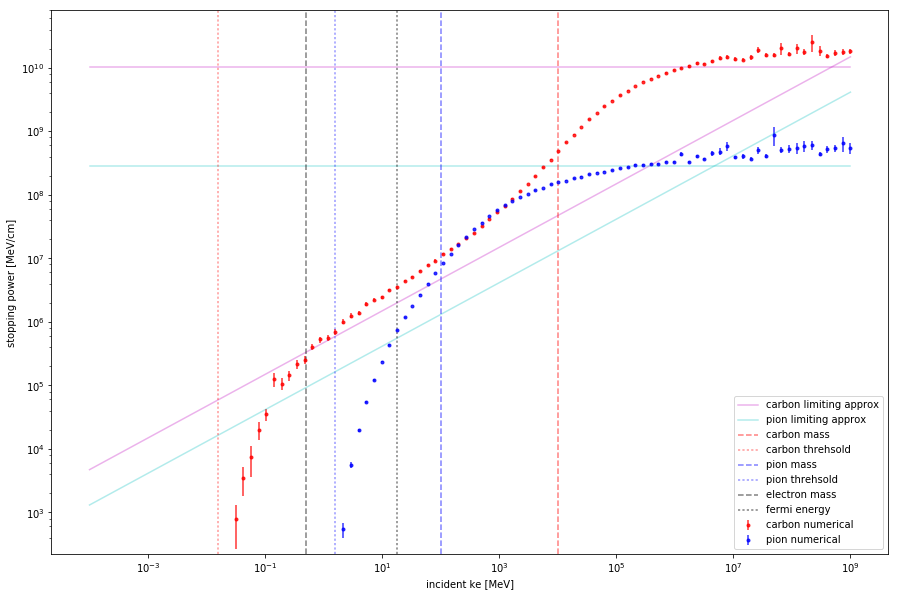

In [43]:
fig, ax = plt.subplots()

# numerical results 
ax.errorbar(ke, dedx_carbon, yerr=dedx_carbon_error, alpha=0.8,
            marker='.', linestyle='', color='r', label='carbon numerical')
ax.errorbar(ke, dedx_pion, yerr=dedx_pion_error, alpha=0.8,
            marker='.', linestyle='', color='b', label='pion numerical')
# limiting approximations
ax.plot(ke, dedx_carbon_jackson_func(ke), alpha=0.3,
        marker='', linestyle='-', color='m', 
        label='carbon limiting approx')
ax.plot(ke, dedx_carbon_riggins_func(ke), alpha=0.3,
        marker='', linestyle='-', color='m')
ax.plot(ke, dedx_pion_jackson_func(ke), alpha=0.3,
        marker='', linestyle='-', color='c')
ax.plot(ke, dedx_pion_riggins_func(ke), alpha=0.3,
        marker='', linestyle='-', color='c', 
        label='pion limiting approx')
# significant energy scales 
ax.axvline(M_carbon, linestyle='--', color='r', alpha=0.5, label="carbon mass")
ax.axvline(momentum_threshold(wd.pfermi, M_carbon), linestyle=':', color='r', alpha=0.4, label="carbon threhsold")
ax.axvline(M_pion, linestyle='--', color='b', alpha=0.5, label="pion mass")
ax.axvline(momentum_threshold(wd.pfermi, M_pion), linestyle=':', color='b', alpha=0.4, label="pion threhsold")
ax.axvline(wd.m, linestyle='--', color='k', alpha=0.5, label="electron mass")
ax.axvline(wd.Efermi, linestyle=':', color='k', alpha=0.5, label="fermi energy")

ax.set_xlabel("incident ke [MeV]")
ax.set_ylabel("stopping power [MeV/cm]")
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend(loc="best")

/home/rjanish/installs/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in divide
/home/rjanish/installs/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in divide
/home/rjanish/installs/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in divide
/home/rjanish/installs/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in divide


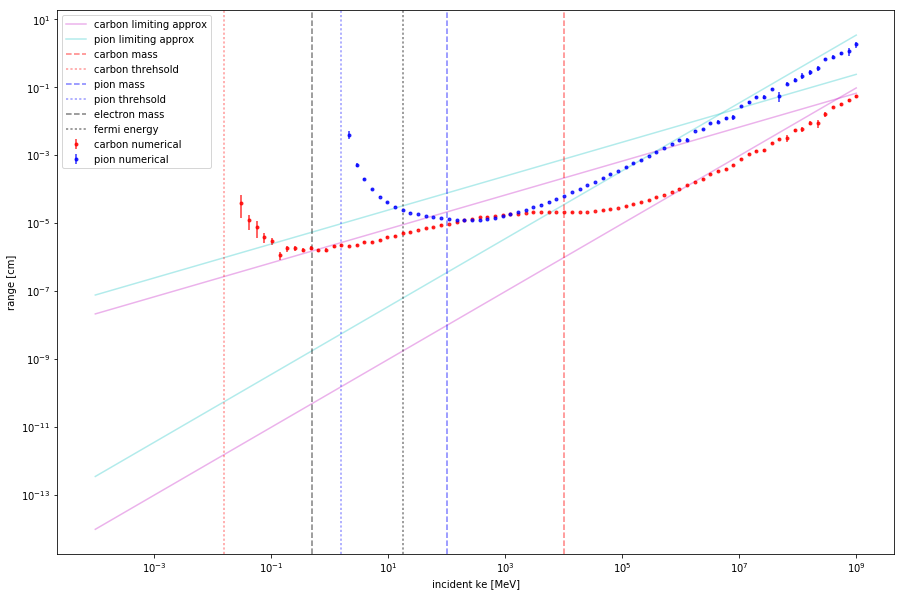

In [44]:
fig, ax = plt.subplots()

# numerical results 
ax.errorbar(ke, ke/dedx_carbon, yerr=ke*dedx_carbon_error/(dedx_carbon**2), alpha=0.8,
            marker='.', linestyle='', color='r', label='carbon numerical')
ax.errorbar(ke, ke/dedx_pion, yerr=ke*dedx_pion_error/(dedx_pion**2), alpha=0.8,
            marker='.', linestyle='', color='b', label='pion numerical')
# limiting approximations
ax.plot(ke, ke/dedx_carbon_jackson_func(ke), alpha=0.3,
        marker='', linestyle='-', color='m')
ax.plot(ke, ke/dedx_carbon_riggins_func(ke), alpha=0.3,
        marker='', linestyle='-', color='m', 
        label='carbon limiting approx')
ax.plot(ke, ke/dedx_pion_jackson_func(ke), alpha=0.3,
        marker='', linestyle='-', color='c')
ax.plot(ke, ke/dedx_pion_riggins_func(ke), alpha=0.3,
        marker='', linestyle='-', color='c', 
        label='pion limiting approx')
# significant energy scales 
ax.axvline(M_carbon, linestyle='--', color='r', alpha=0.5, label="carbon mass")
ax.axvline(momentum_threshold(wd.pfermi, M_carbon), linestyle=':', color='r', alpha=0.4, label="carbon threhsold")
ax.axvline(M_pion, linestyle='--', color='b', alpha=0.5, label="pion mass")
ax.axvline(momentum_threshold(wd.pfermi, M_pion), linestyle=':', color='b', alpha=0.4, label="pion threhsold")
ax.axvline(wd.m, linestyle='--', color='k', alpha=0.5, label="electron mass")
ax.axvline(wd.Efermi, linestyle=':', color='k', alpha=0.5, label="fermi energy")

ax.set_xlabel("incident ke [MeV]")
ax.set_ylabel("range [cm]")
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend(loc="best")

The low energy behavior does not quite match the expectation of $E^{1/2}$, but there are hints.  The pion curve is garbage.  But for the carbon, the curve appears to have slope $1$ just left of the flat portion, and then this slope seems to shallow a bit before it cuts off due to Pauli blocking.  

The $\sim E^{1/2}$ is due to finding $dE/dt \sim E$ and then dividing by the incident velocity $v \sim E^{1/2}$. For a relativistic incidnt, $v\sim 1$ should give a linear stopping power. So perhaps there are four regimes in this plot: Pauli cut off, non-relativistic stationary incident, relativistic stationary incident, and relativistic incident with stationary electrons. For different incident masses, these regions may overlap.  In the pion case it seems the cut off crushes any non-relativistic stationary behavior. 

A very heavy incident will push the Pauli cut off to lower energy, and the relativistic transition to larger energies - hopefully this will open up a clear $E^{1/2}$ region. 

#### Very heavy incident particle

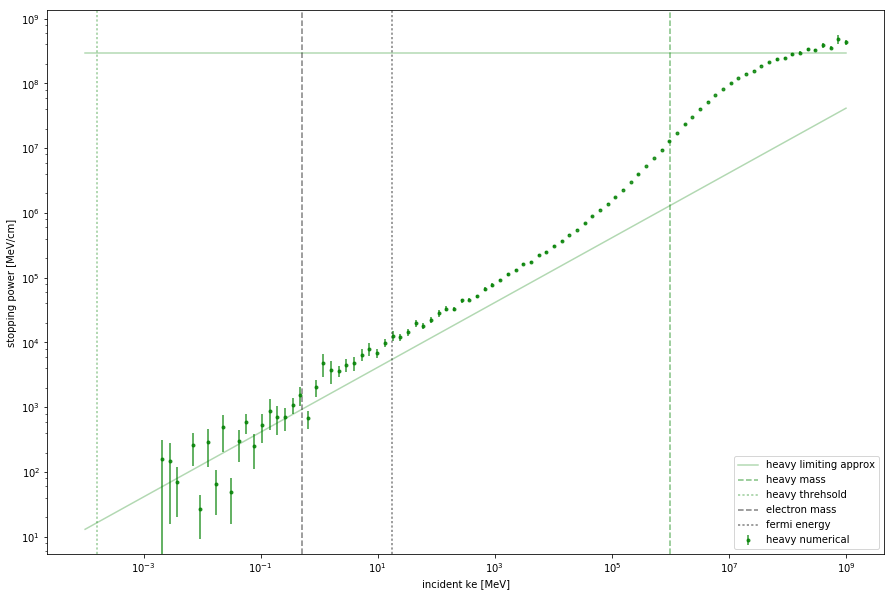

In [45]:
fig, ax = plt.subplots()

# numerical results 
ax.errorbar(ke, dedx_heavy, yerr=dedx_heavy_error, alpha=0.8,
            marker='.', linestyle='', color='g', label='heavy numerical')
# limiting approximations
ax.plot(ke, dedx_heavy_jackson_func(ke), alpha=0.3,
        marker='', linestyle='-', color='g')
ax.plot(ke, dedx_heavy_riggins_func(ke), alpha=0.3,
        marker='', linestyle='-', color='g', 
        label='heavy limiting approx')
# significant energy scales 
ax.axvline(M_heavy, linestyle='--', color='g', alpha=0.5, label="heavy mass")
ax.axvline(momentum_threshold(wd.pfermi, M_heavy), linestyle=':', color='g', alpha=0.4, label="heavy threhsold")
ax.axvline(wd.m, linestyle='--', color='k', alpha=0.5, label="electron mass")
ax.axvline(wd.Efermi, linestyle=':', color='k', alpha=0.5, label="fermi energy")

ax.set_xlabel("incident ke [MeV]")
ax.set_ylabel("stopping power [MeV/cm]")
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend(loc="best")

/home/rjanish/installs/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in divide
/home/rjanish/installs/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in divide


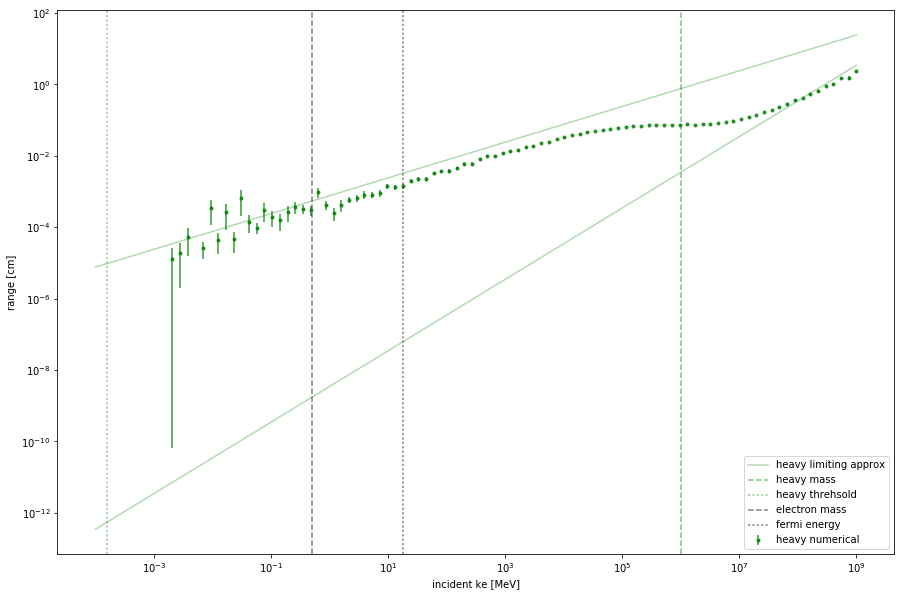

In [46]:
fig, ax = plt.subplots()

# numerical results 
ax.errorbar(ke, ke/dedx_heavy, yerr=ke*dedx_heavy_error/(dedx_heavy**2), alpha=0.8,
            marker='.', linestyle='', color='g', label='heavy numerical')
# limiting approximations
ax.plot(ke, ke/dedx_heavy_jackson_func(ke), alpha=0.3,
        marker='', linestyle='-', color='g')
ax.plot(ke, ke/dedx_heavy_riggins_func(ke), alpha=0.3,
        marker='', linestyle='-', color='g', 
        label='heavy limiting approx')
# significant energy scales 
ax.axvline(M_heavy, linestyle='--', color='g', alpha=0.5, label="heavy mass")
ax.axvline(momentum_threshold(wd.pfermi, M_heavy), linestyle=':', color='g', alpha=0.4, label="heavy threhsold")
ax.axvline(wd.m, linestyle='--', color='k', alpha=0.5, label="electron mass")
ax.axvline(wd.Efermi, linestyle=':', color='k', alpha=0.5, label="fermi energy")

ax.set_xlabel("incident ke [MeV]")
ax.set_ylabel("range [cm]")
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend(loc="best")

Here we do have the $1/2$ scaling as expected! Note that the over